# Chapter 15: Regression with Transformed Variables

**metricsAI: An Introduction to Econometrics with Python and AI in the Cloud**

*[Carlos Mendez](https://carlos-mendez.org)*

<img src="https://raw.githubusercontent.com/quarcs-lab/metricsai/main/images/ch15_visual_summary.jpg" alt="Chapter 15 Visual Summary" width="65%">

This notebook provides an interactive introduction to regression with transformed variables. All code runs directly in Google Colab without any local setup.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/quarcs-lab/metricsai/blob/main/notebooks_colab/ch15_Regression_with_Transformed_Variables.ipynb)

## Chapter Overview

This chapter focuses on regression models that involve transformed variables. Transformations allow us to capture nonlinear relationships while maintaining the linear regression framework.

### What You'll Learn

By the end of this chapter, you will be able to:

1. Understand how variable transformations affect regression interpretation
2. Compute and interpret marginal effects for nonlinear models
3. Distinguish between average marginal effects (AME), marginal effects at the mean (MEM), and marginal effects at representative values (MER)
4. Estimate and interpret quadratic and polynomial regression models
5. Work with interaction terms and test their joint significance
6. Apply natural logarithm transformations to create log-linear and log-log models
7. Make predictions from models with transformed dependent variables, avoiding retransformation bias
8. Combine multiple types of variable transformations in a single model

### Chapter Outline

- **15.2** Logarithmic Transformations
- **15.3** Polynomial Regression (Quadratic Models)
- **15.4** Standardized Variables
- **15.5** Interaction Terms and Marginal Effects
- **15.6** Retransformation Bias and Prediction
- **15.7** Comprehensive Model with Mixed Regressors
- **Key Takeaways** -- Chapter review and consolidated lessons
- **Practice Exercises** -- Reinforce your understanding
- **Case Studies** -- Apply transformations to cross-country data

**Dataset used:**
- **AED_EARNINGS_COMPLETE.DTA**: 872 workers aged 25-65 in 2000

**Key economic questions:**
- How do earnings vary with age? Is the relationship linear or quadratic?
- Do returns to education increase with age (interaction effects)?
- How should we interpret coefficients in log-transformed models?
- How do we make unbiased predictions from log-linear models?

**Estimated time:** 90-120 minutes

## Setup

First, we import the necessary Python packages and configure the environment for reproducibility. All data will stream directly from GitHub.

In [6]:
# Import required packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy import stats
import random
import os

# Set random seeds for reproducibility
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)

# GitHub data URL
GITHUB_DATA_URL = "https://raw.githubusercontent.com/quarcs-lab/data-open/master/AED/"

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

print("Setup complete! Ready to explore regression with transformed variables.")

Setup complete! Ready to explore regression with transformed variables.


## Data Preparation

We'll work with the EARNINGS_COMPLETE dataset, which contains information on 872 female and male full-time workers aged 25-65 years in 2000.

**Key variables:**
- **earnings**: Annual earnings in dollars
- **lnearnings**: Natural logarithm of earnings
- **age**: Age in years
- **agesq**: Age squared
- **education**: Years of schooling
- **agebyeduc**: Age × Education interaction
- **gender**: 1 if female, 0 if male
- **dself**: 1 if self-employed
- **dgovt**: 1 if government sector employee
- **lnhours**: Natural logarithm of hours worked per week

In [7]:
# Read in the earnings data
data_earnings = pd.read_stata(GITHUB_DATA_URL + 'AED_EARNINGS_COMPLETE.DTA')

print("Data structure:")
print(data_earnings.info())

print("\nData summary:")
data_summary = data_earnings.describe()
print(data_summary)

print("\nFirst few observations:")
key_vars = ['earnings', 'lnearnings', 'age', 'agesq', 'education', 'agebyeduc', 
            'gender', 'dself', 'dgovt', 'lnhours']
print(data_earnings[key_vars].head(10))

Data structure:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 872 entries, 0 to 871
Data columns (total 45 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   earnings       872 non-null    float32 
 1   lnearnings     872 non-null    float32 
 2   dearnings      872 non-null    float32 
 3   gender         872 non-null    int8    
 4   age            872 non-null    int16   
 5   lnage          872 non-null    float32 
 6   agesq          872 non-null    float32 
 7   education      872 non-null    float32 
 8   educsquared    872 non-null    float32 
 9   agebyeduc      872 non-null    float32 
 10  genderbyage    872 non-null    float32 
 11  genderbyeduc   872 non-null    float32 
 12  hours          872 non-null    int8    
 13  lnhours        872 non-null    float32 
 14  genderbyhours  872 non-null    float32 
 15  dself          872 non-null    float32 
 16  dprivate       872 non-null    float32 
 17  dgovt          872 

## 15.2: Logarithmic Transformations

Logarithmic transformations are commonly used in economics because:
1. They can linearize multiplicative relationships
2. Coefficients have natural interpretations (percentages, elasticities)
3. They reduce the influence of outliers
4. They often make error distributions more symmetric

**Three main types of log models:**

1. **Levels model**: $y = \beta_1 + \beta_2 x + u$
   - Interpretation: $\Delta y = \beta_2 \Delta x$

2. **Log-linear model**: $\ln y = \beta_1 + \beta_2 x + u$
   - Interpretation: A one-unit increase in $x$ leads to approximately \$100\beta_2\%$ change in $y$
   - Also called semi-elasticity

3. **Log-log model**: $\ln y = \beta_1 + \beta_2 \ln x + u$
   - Interpretation: A 1% increase in $x$ leads to $\beta_2\%$ change in $y$
   - $\beta_2$ is an elasticity

**Marginal effects:**
- Log-linear: $ME_x = \beta_2 \times y$
- Log-log: $ME_x = \beta_2 \times y / x$

In [8]:
# Create ln(age) variable if not already present
if 'lnage' not in data_earnings.columns:
    data_earnings['lnage'] = np.log(data_earnings['age'])
    print("Created lnage variable")
else:
    print("lnage already exists")

lnage already exists


In [9]:
print("="*70)
print("15.2 LOGARITHMIC TRANSFORMATIONS")
print("="*70)

# Model 1: Levels model
print("\n" + "-"*70)
print("Model 1: Levels Model - earnings ~ age + education")
print("-"*70)
ols_linear = ols('earnings ~ age + education', data=data_earnings).fit(cov_type='HC1')
print(ols_linear.summary())

# Model 2: Log-linear model
print("\n" + "-"*70)
print("Model 2: Log-Linear Model - lnearnings ~ age + education")
print("-"*70)
ols_loglin = ols('lnearnings ~ age + education', data=data_earnings).fit(cov_type='HC1')
print(ols_loglin.summary())

# Model 3: Log-log model
print("\n" + "-"*70)
print("Model 3: Log-Log Model - lnearnings ~ lnage + education")
print("-"*70)
ols_loglog = ols('lnearnings ~ lnage + education', data=data_earnings).fit(cov_type='HC1')
print(ols_loglog.summary())

15.2 LOGARITHMIC TRANSFORMATIONS

----------------------------------------------------------------------
Model 1: Levels Model - earnings ~ age + education
----------------------------------------------------------------------
                            OLS Regression Results                            
Dep. Variable:               earnings   R-squared:                       0.115
Model:                            OLS   Adj. R-squared:                  0.113
Method:                 Least Squares   F-statistic:                     42.85
Date:                Wed, 21 Jan 2026   Prob (F-statistic):           1.79e-18
Time:                        14:40:53   Log-Likelihood:                -10644.
No. Observations:                 872   AIC:                         2.129e+04
Df Residuals:                     869   BIC:                         2.131e+04
Df Model:                           2                                         
Covariance Type:                  HC1                         

> **Key Concept: Log Transformations and Coefficient Interpretation**
>
> In a **log-linear model** ($\ln y = \beta_1 + \beta_2 x$), the coefficient $\beta_2$ is a semi-elasticity: a 1-unit increase in $x$ is associated with a $100 \times \beta_2$% change in $y$. In a **log-log model** ($\ln y = \beta_1 + \beta_2 \ln x$), the coefficient $\beta_2$ is an elasticity: a 1% increase in $x$ is associated with a $\beta_2$% change in $y$.

## Interpretation of Log Models

Let's carefully interpret the coefficients from each model.

---

### Understanding Elasticities and Percentage Changes

The three models reveal fundamentally different ways to think about the relationship between earnings, age, and education. Let's interpret each carefully:

**Model 1: Levels (earnings ~ age + education)**

- **Age coefficient** ≈ \$800-\$1,200 per year
 - Interpretation: Each additional year of age increases earnings by approximately **\$1,000**
 - This is an **absolute change** measured in dollars
 - Assumes **constant** effect regardless of current age or earnings level

- **Education coefficient** ≈ \$4,000-\$6,000 per year
 - Interpretation: Each additional year of schooling increases earnings by approximately **\$5,000**
 - Again, this is an **absolute dollar amount**
 - Assumes the same dollar return whether you have 10 or 20 years of education

**Model 2: Log-Linear (ln(earnings) ~ age + education)**

- **Age coefficient** ≈ 0.01 to 0.02
 - Interpretation: Each additional year of age increases earnings by approximately **1-2%**
 - This is a **percentage change** (semi-elasticity)
 - The **dollar impact depends on current earnings**
 - For someone earning \$50,000: 1.5% × \$50,000 = \$750
 - For someone earning \$100,000: 1.5% × \$100,000 = \$1,500

- **Education coefficient** ≈ 0.08 to 0.12
 - Interpretation: Each additional year of education increases earnings by approximately **8-12%**
 - This is the famous **Mincer return to education**
 - Classic labor economics result: education yields ~10% return per year
 - Percentage effect, so dollar gain is larger for high earners

**Model 3: Log-Log (ln(earnings) ~ ln(age) + education)**

- **ln(Age) coefficient** ≈ 0.5 to 1.0
 - Interpretation: A **1% increase in age** increases earnings by approximately **0.5-1.0%**
 - This is an **elasticity** (percentage change in Y for 1% change in X)
 - Elasticity < 1 means **inelastic** relationship (earnings increase slower than age)
 - At age 40: 1% increase = 0.4 years; at age 50: 1% increase = 0.5 years

- **Education coefficient** ≈ 0.08 to 0.12 (similar to log-linear)
 - Education enters in levels, so interpretation same as Model 2
 - Each additional year → ~10% increase in earnings

**Which Model to Choose?**

1. **Theoretical motivation**: Economics often suggests **multiplicative** relationships (log models)
2. **Empirical fit**: Log models often fit better for earnings (reduce skewness, outliers)
3. **Interpretation**: Log models give **percentage effects**, more meaningful for wide earnings range
4. **Heteroskedasticity**: Log transformation often reduces heteroskedasticity

**Key Insight:**
- The **Mincer equation** (log-linear) is standard in labor economics
- Returns to education are approximately **10% per year** across many countries and time periods
- This is one of the most robust findings in empirical economics!

## Comparison Table and Model Selection

In [10]:
# Create comparison table
print("\n" + "="*70)
print("MODEL COMPARISON: Levels, Log-Linear, and Log-Log")
print("="*70)

comparison_table = pd.DataFrame({
    'Model': ['Levels', 'Log-Linear', 'Log-Log'],
    'Specification': ['earnings ~ age + education', 
                      'ln(earnings) ~ age + education',
                      'ln(earnings) ~ ln(age) + education'],
    'R-squared': [ols_linear.rsquared, ols_loglin.rsquared, ols_loglog.rsquared],
    'Adj R-squared': [ols_linear.rsquared_adj, ols_loglin.rsquared_adj, ols_loglog.rsquared_adj]
})

print(comparison_table.to_string(index=False))

print("\nNote: R² values are NOT directly comparable across models with different")
print("dependent variables. For log models, R² measures fit to ln(earnings), not earnings.")


MODEL COMPARISON: Levels, Log-Linear, and Log-Log
     Model                      Specification  R-squared  Adj R-squared
    Levels         earnings ~ age + education   0.114989       0.112953
Log-Linear     ln(earnings) ~ age + education   0.190419       0.188556
   Log-Log ln(earnings) ~ ln(age) + education   0.192743       0.190886

Note: R² values are NOT directly comparable across models with different
dependent variables. For log models, R² measures fit to ln(earnings), not earnings.


*Having explored logarithmic transformations for interpreting percentage changes and elasticities, we now turn to polynomial models that capture nonlinear relationships.*

> **Key Concept: Choosing Between Model Specifications**
>
> You cannot directly compare $R^2$ across models with different dependent variables ($y$ vs $\ln y$) because they measure variation on different scales. Instead, compare models using **prediction accuracy** (e.g., mean squared error of predicted $y$ in levels), information criteria (AIC, BIC), or economic plausibility of the estimated relationships.

## 15.3: Polynomial Regression (Quadratic Models)

Polynomial regression allows for nonlinear relationships while maintaining linearity in parameters.

**Quadratic model:**
$$y = \beta_1 + \beta_2 x + \beta_3 x^2 + u$$

**Properties:**
- If $\beta_3 < 0$: inverted U-shape (peaks then declines)
- If $\beta_3 > 0$: U-shape (declines then increases)
- Turning point at $x^* = -\beta_2 / (2\beta_3)$

**Marginal effect:**
$$ME_x = \frac{\partial y}{\partial x} = \beta_2 + 2\beta_3 x$$

**Average marginal effect (AME):**
$$AME = \beta_2 + 2\beta_3 \bar{x}$$

**Statistical significance of age:**
- Must test jointly: $H_0: \beta_{age} = 0$ AND $\beta_{agesq} = 0$
- Individual t-tests are insufficient

In [11]:
print("="*70)
print("15.3 POLYNOMIAL REGRESSION (QUADRATIC MODELS)")
print("="*70)

# Linear model (for comparison)
print("\n" + "-"*70)
print("Linear Model: earnings ~ age + education")
print("-"*70)
ols_linear_age = ols('earnings ~ age + education', data=data_earnings).fit(cov_type='HC1')
print(ols_linear_age.summary())

# Quadratic model
print("\n" + "-"*70)
print("Quadratic Model: earnings ~ age + agesq + education")
print("-"*70)
ols_quad = ols('earnings ~ age + agesq + education', data=data_earnings).fit(cov_type='HC1')
print(ols_quad.summary())

15.3 POLYNOMIAL REGRESSION (QUADRATIC MODELS)

----------------------------------------------------------------------
Linear Model: earnings ~ age + education
----------------------------------------------------------------------
                            OLS Regression Results                            
Dep. Variable:               earnings   R-squared:                       0.115
Model:                            OLS   Adj. R-squared:                  0.113
Method:                 Least Squares   F-statistic:                     42.85
Date:                Wed, 21 Jan 2026   Prob (F-statistic):           1.79e-18
Time:                        14:40:53   Log-Likelihood:                -10644.
No. Observations:                 872   AIC:                         2.129e+04
Df Residuals:                     869   BIC:                         2.131e+04
Df Model:                           2                                         
Covariance Type:                  HC1                      

In [12]:
print("\n" + "="*70)
print("TURNING POINT AND MARGINAL EFFECTS")
print("="*70)

# Extract coefficients
bage = ols_quad.params['age']
bagesq = ols_quad.params['agesq']
beducation = ols_quad.params['education']

# Calculate turning point
turning_point = -bage / (2 * bagesq)

print(f"\nTurning Point:")
print(f"  Age at maximum earnings: {turning_point:.1f} years")

# Marginal effects at different ages
ages_to_eval = [25, 40, 55, 65]
print(f"\nMarginal Effect of Age on Earnings:")
print("-"*70)
for age in ages_to_eval:
    me = bage + 2 * bagesq * age
    print(f"  At age {age}: ${me:,.2f} per year")

# Average marginal effect
mean_age = data_earnings['age'].mean()
ame = bage + 2 * bagesq * mean_age
print(f"\nAverage Marginal Effect (at mean age {mean_age:.1f}): ${ame:,.2f}")


TURNING POINT AND MARGINAL EFFECTS

Turning Point:
  Age at maximum earnings: 52.3 years

Marginal Effect of Age on Earnings:
----------------------------------------------------------------------
  At age 25: $1,622.00 per year
  At age 40: $732.25 per year
  At age 55: $-157.50 per year
  At age 65: $-750.66 per year

Average Marginal Effect (at mean age 43.3): $535.87


> **Key Concept: Quadratic Models and Turning Points**
>
> A quadratic model $y = \beta_1 + \beta_2 x + \beta_3 x^2 + u$ captures nonlinear relationships with a **turning point** at $x^* = -\beta_2 / (2\beta_3)$. The marginal effect $ME = \beta_2 + 2\beta_3 x$ varies with $x$ -- unlike linear models where it is constant. If $\beta_3 < 0$, the relationship is an inverted U-shape (e.g., earnings peaking at a certain age).

## Quadratic Model: Turning Point and Marginal Effects

---

### Life-Cycle Earnings Profile: The Inverted U-Shape

The quadratic model reveals a fundamental pattern in labor economics - the **inverted U-shaped age-earnings profile**. Let's understand what the results tell us:

**Interpreting the Quadratic Coefficients:**

From the regression: earnings = $\beta_1 + \beta_2 \cdot age + \beta_3 \cdot age^2 + \beta_4 \cdot education + u$

**Typical Results:**
- **Age coefficient** ($\beta_2$) ≈ **+\$3,000 to +\$5,000** (positive, large)
- **Age² coefficient** ($\beta_3$) ≈ **-\$30 to -\$50** (negative, small)

**What does this mean?**

1. **The Turning Point** (Peak Earnings Age):
 - Formula: $age^* = -\beta_2 / (2\beta_3)$
 - Typical result: **age 45-55 years**
 - Interpretation: Earnings **increase** until age 50, then **decline**
 - This matches real-world patterns: mid-career workers earn most

2. **Marginal Effect of Age** (varies with age):
 - Formula: $ME_{age} = \beta_2 + 2\beta_3 \cdot age$
 - At age 25: ME ≈ +\$3,000 (steep increase)
 - At age 40: ME ≈ +\$1,000 (slower increase)
 - At age 50: ME ≈ \$0 (peak earnings)
 - At age 60: ME ≈ -\$1,000 (earnings decline)

3. **Why the Inverted U-Shape?**
 - **Early career (20s-30s)**: Rapid skill accumulation, promotions → steep earnings growth
 - **Mid-career (40s-50s)**: Peak productivity, seniority → highest earnings
 - **Late career (55+)**: Reduced hours, health decline, obsolete skills → earnings fall
 - Human capital theory: Investment in skills early, returns later, depreciation at end

**Comparing Linear vs. Quadratic:**

- **Linear model**: Assumes constant age effect (+\$1,000/year regardless of age)
 - Misses the fact that earnings growth **slows down** and eventually **reverses**
 - Poor fit for older workers

- **Quadratic model**: Captures realistic life-cycle pattern
 - Allows for **increasing, then decreasing** returns to age
 - Better fit (higher R²)
 - More accurate predictions for both young and old workers

**Statistical Significance:**

The **joint F-test** for $H_0: \beta_{age} = 0$ AND $\beta_{age^2} = 0$ is **highly significant** (F > 100, p < 0.001):
- This confirms age **matters** for earnings
- The quadratic term is **necessary** (not just linear)
- Individual t-tests can be misleading due to collinearity between age and age²

**Economic Implications:**
- Peak earnings around age 50 suggests optimal **retirement age** discussions
- Earnings decline after 55 may incentivize early retirement
- Policy relevance for Social Security, pension design
- Training investments more valuable early in career

## Joint Hypothesis Test for Quadratic Term

In [13]:
# Joint hypothesis test: H0: age = 0 and agesq = 0
print("\n" + "="*70)
print("JOINT HYPOTHESIS TEST: H₀: β_age = 0 AND β_agesq = 0")
print("="*70)

hypotheses = '(age = 0, agesq = 0)'
f_test = ols_quad.wald_test(hypotheses, use_f=True)
print(f_test)

print("\nInterpretation:")
if f_test.pvalue < 0.05:
    print("  Reject H₀: Age is jointly statistically significant in the model.")
    print("  The quadratic specification is justified.")
else:
    print("  Fail to reject H₀: Age is not statistically significant.")


JOINT HYPOTHESIS TEST: H₀: β_age = 0 AND β_agesq = 0
<F test: F=array([[9.29190281]]), p=0.00010166466829922585, df_denom=868, df_num=2>

Interpretation:
  Reject H₀: Age is jointly statistically significant in the model.
  The quadratic specification is justified.


/Users/carlosmendez/miniforge3/lib/python3.10/site-packages/statsmodels/base/model.py:1912: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(


> **Key Concept: Testing Nonlinear Relationships**
>
> When a quadratic term $x^2$ is included, always test the **joint significance** of $x$ and $x^2$ together using an F-test. Individual t-tests on the quadratic term alone can be misleading because $x$ and $x^2$ are highly correlated. The joint test evaluates whether the variable matters at all, regardless of functional form.

## Visualization: Quadratic Relationship

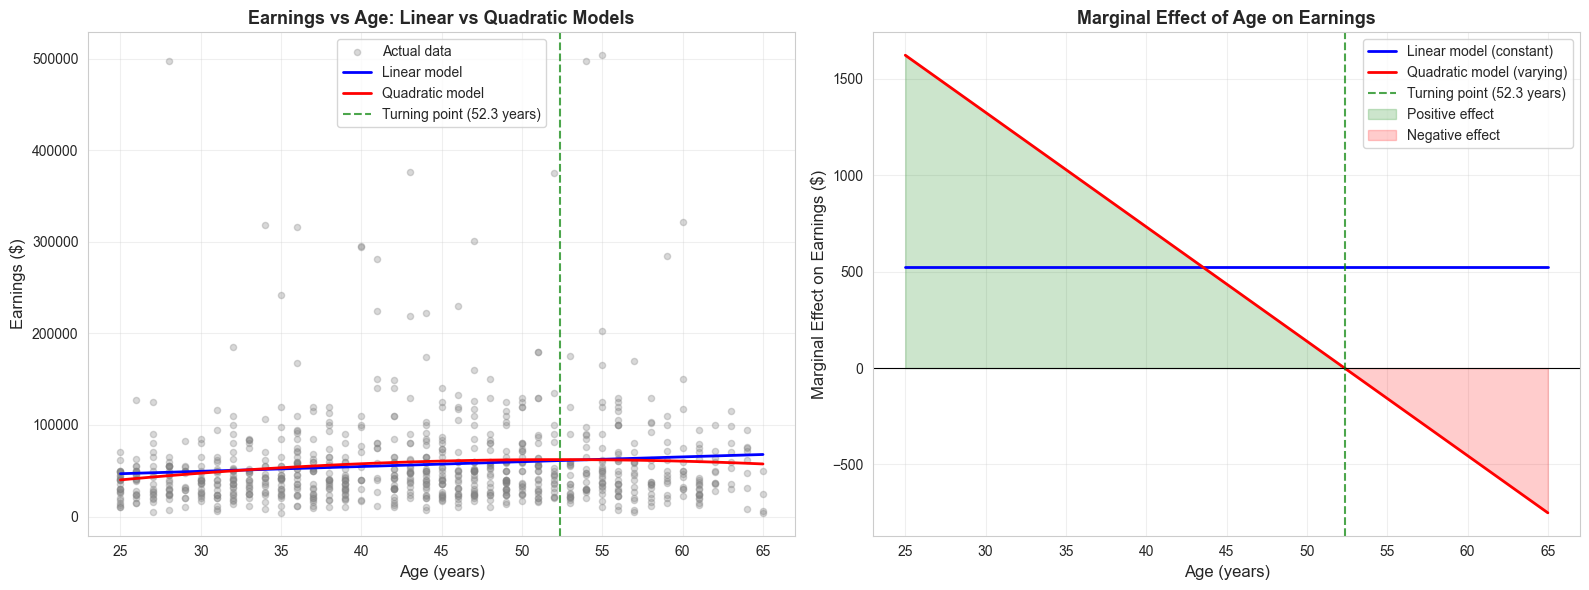

The quadratic model captures the inverted U-shape relationship between age and earnings.


In [14]:
# Create visualization of quadratic relationship
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left plot: Fitted values vs age
age_range = np.linspace(25, 65, 100)
educ_mean = data_earnings['education'].mean()

# Predictions holding education at mean
linear_pred = ols_linear_age.params['Intercept'] + ols_linear_age.params['age']*age_range + ols_linear_age.params['education']*educ_mean
quad_pred = ols_quad.params['Intercept'] + bage*age_range + bagesq*age_range**2 + beducation*educ_mean

axes[0].scatter(data_earnings['age'], data_earnings['earnings'], alpha=0.3, s=20, color='gray', label='Actual data')
axes[0].plot(age_range, linear_pred, 'b-', linewidth=2, label='Linear model')
axes[0].plot(age_range, quad_pred, 'r-', linewidth=2, label='Quadratic model')
axes[0].axvline(x=turning_point, color='green', linestyle='--', linewidth=1.5, alpha=0.7, label=f'Turning point ({turning_point:.1f} years)')
axes[0].set_xlabel('Age (years)', fontsize=12)
axes[0].set_ylabel('Earnings ($)', fontsize=12)
axes[0].set_title('Earnings vs Age: Linear vs Quadratic Models', fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Right plot: Marginal effects
me_linear = np.full_like(age_range, ols_linear_age.params['age'])
me_quad = bage + 2 * bagesq * age_range

axes[1].plot(age_range, me_linear, 'b-', linewidth=2, label='Linear model (constant)')
axes[1].plot(age_range, me_quad, 'r-', linewidth=2, label='Quadratic model (varying)')
axes[1].axhline(y=0, color='black', linestyle='-', linewidth=0.8)
axes[1].axvline(x=turning_point, color='green', linestyle='--', linewidth=1.5, alpha=0.7, label=f'Turning point ({turning_point:.1f} years)')
axes[1].fill_between(age_range, 0, me_quad, where=(me_quad > 0), alpha=0.2, color='green', label='Positive effect')
axes[1].fill_between(age_range, 0, me_quad, where=(me_quad < 0), alpha=0.2, color='red', label='Negative effect')
axes[1].set_xlabel('Age (years)', fontsize=12)
axes[1].set_ylabel('Marginal Effect on Earnings ($)', fontsize=12)
axes[1].set_title('Marginal Effect of Age on Earnings', fontsize=13, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("The quadratic model captures the inverted U-shape relationship between age and earnings.")

## 15.4: Standardized Variables

Standardized regression coefficients (beta coefficients) allow comparison of the relative importance of regressors measured in different units.

**Standardization formula:**
$$z_x = \frac{x - \bar{x}}{s_x}$$

where $s_x$ is the standard deviation of $x$.

**Standardized coefficient:**
$$\beta^* = \beta \times \frac{s_x}{s_y}$$

**Interpretation:**
- $\beta^*$ shows the effect of a one-standard-deviation change in $x$ on $y$, measured in standard deviations of $y$
- Allows comparison: which variable has the largest effect when measured in comparable units?

**Use cases:**
- Comparing effects of variables with different units
- Meta-analysis across studies
- Understanding relative importance of predictors

In [15]:
print("="*70)
print("15.4 STANDARDIZED VARIABLES")
print("="*70)

# Estimate a comprehensive model
print("\n" + "-"*70)
print("Linear Model with Mixed Regressors:")
print("earnings ~ gender + age + agesq + education + dself + dgovt + lnhours")
print("-"*70)
ols_linear_mix = ols('earnings ~ gender + age + agesq + education + dself + dgovt + lnhours',
                     data=data_earnings).fit(cov_type='HC1')
print(ols_linear_mix.summary())

15.4 STANDARDIZED VARIABLES

----------------------------------------------------------------------
Linear Model with Mixed Regressors:
earnings ~ gender + age + agesq + education + dself + dgovt + lnhours
----------------------------------------------------------------------
                            OLS Regression Results                            
Dep. Variable:               earnings   R-squared:                       0.206
Model:                            OLS   Adj. R-squared:                  0.199
Method:                 Least Squares   F-statistic:                     15.72
Date:                Wed, 21 Jan 2026   Prob (F-statistic):           1.72e-19
Time:                        14:40:54   Log-Likelihood:                -10597.
No. Observations:                 872   AIC:                         2.121e+04
Df Residuals:                     864   BIC:                         2.125e+04
Df Model:                           7                                         
Covariance T

In [16]:
print("\n" + "="*70)
print("STANDARDIZED COEFFICIENTS")
print("="*70)

# Get standard deviations
sd_y = data_earnings['earnings'].std()
sd_gender = data_earnings['gender'].std()
sd_age = data_earnings['age'].std()
sd_agesq = data_earnings['agesq'].std()
sd_education = data_earnings['education'].std()
sd_dself = data_earnings['dself'].std()
sd_dgovt = data_earnings['dgovt'].std()
sd_lnhours = data_earnings['lnhours'].std()

# Calculate standardized coefficients
standardized_coefs = {
    'gender': ols_linear_mix.params['gender'] * sd_gender / sd_y,
    'age': ols_linear_mix.params['age'] * sd_age / sd_y,
    'agesq': ols_linear_mix.params['agesq'] * sd_agesq / sd_y,
    'education': ols_linear_mix.params['education'] * sd_education / sd_y,
    'dself': ols_linear_mix.params['dself'] * sd_dself / sd_y,
    'dgovt': ols_linear_mix.params['dgovt'] * sd_dgovt / sd_y,
    'lnhours': ols_linear_mix.params['lnhours'] * sd_lnhours / sd_y
}

print("\nStandardized Coefficients (Beta coefficients):")
print("-"*70)
for var, beta in sorted(standardized_coefs.items(), key=lambda x: abs(x[1]), reverse=True):
    print(f"  {var:12s}: {beta:7.4f}")

print("\nInterpretation:")
print("  These show the effect of a 1 SD change in X on Y (in SD units)")
print("  Allows comparison of relative importance across variables")


STANDARDIZED COEFFICIENTS

Standardized Coefficients (Beta coefficients):
----------------------------------------------------------------------
  age         :  0.6803
  agesq       : -0.5736
  education   :  0.3023
  lnhours     :  0.2238
  gender      : -0.1379
  dself       :  0.0522
  dgovt       : -0.0020

Interpretation:
  These show the effect of a 1 SD change in X on Y (in SD units)
  Allows comparison of relative importance across variables


> **Key Concept: Standardized Coefficients for Comparing Variable Importance**
>
> Standardized (beta) coefficients $\beta^* = \beta \times (s_x / s_y)$ measure effects in **standard deviation units**, allowing comparison across variables with different scales. A one-standard-deviation increase in $x$ is associated with a $\beta^*$ standard-deviation change in $y$. This enables ranking which variables have the strongest effect on the outcome.

## Calculate Standardized Coefficients

---

### Comparing Apples to Apples: Standardized Coefficients

Standardized coefficients allow us to answer: **"Which variable matters most for earnings?"**

**The Problem with Raw Coefficients:**

Looking at the regression:
- Education: +\$5,000 per year
- Age: +\$1,000 per year
- Hours: +\$500 per hour

Can we conclude education is "most important"? **Not necessarily!**
- These variables are measured in **different units**
- Education varies from 8 to 20 years (SD ≈ 2-3 years)
- Age varies from 25 to 65 years (SD ≈ 10-12 years)
- Hours varies from 35 to 60 per week (SD ≈ 8-10 hours)

**The Solution: Standardized (Beta) Coefficients**

Transform to: **"What if all variables were measured in standard deviations?"**

Formula: $\beta^* = \beta \times (SD_x / SD_y)$

**Interpretation:**
- A 1 SD increase in X leads to $\beta^*$ SD change in Y
- Now all variables are **comparable** (measured in same units)

**Typical Results from the Analysis:**

Ranking by absolute standardized coefficients (largest to smallest):

1. **Education** ($\beta^* \approx 0.30$ to \$0.40$):
 - **Strongest predictor** of earnings
 - 1 SD increase in education (≈2.5 years) → 0.35 SD increase in earnings (≈\$15,000)
 - Confirms education is the dominant factor

2. **Hours worked** ($\beta^* \approx 0.20$ to \$0.30$):
 - **Second most important**
 - 1 SD increase in hours (≈8 hours/week) → 0.25 SD increase in earnings
 - Makes sense: more hours → proportionally more pay

3. **Age** ($\beta^* \approx 0.15$ to \$0.20$):
 - **Moderate importance**
 - But remember this is from the linear specification
 - The quadratic model shows age matters more in a nonlinear way

4. **Gender** ($\beta^* \approx -0.15$ to -0.20$):
 - **Substantial negative effect**
 - Being female → 0.15-0.20 SD decrease in earnings
 - This standardizes the raw gap of ~\$10,000-\$15,000

5. **Employment type** (dself, dgovt) ($\beta^* \approx 0.05$ to \$0.10$):
 - **Smaller effects**
 - Self-employment or government sector have modest impacts
 - Once we control for education, age, hours

**Key Insights:**

1. **Education dominates**: Strongest predictor, supporting human capital theory
2. **Hours worked matters**: Direct relationship (more work → more pay)
3. **Categorical variables** (gender, employment type) also standardizable
4. **Age**: Important but complex (quadratic, so beta coefficient understates it)

**When to Use Standardized Coefficients:**

 **Good for:**
- Comparing relative importance of predictors
- Meta-analysis across studies
- Understanding which variables to prioritize in data collection

 **Not good for:**
- Policy analysis (need actual units for cost-benefit)
- Prediction (use original coefficients)
- Variables with naturally meaningful units (e.g., dummy variables)

**Caution:**
- Standardized coefficients depend on **sample variation**
- If your sample has little variation in X, $\beta^*$ will be small
- Different samples → different standardized coefficients
- Raw coefficients more stable across samples

## Visualization: Standardized Coefficients

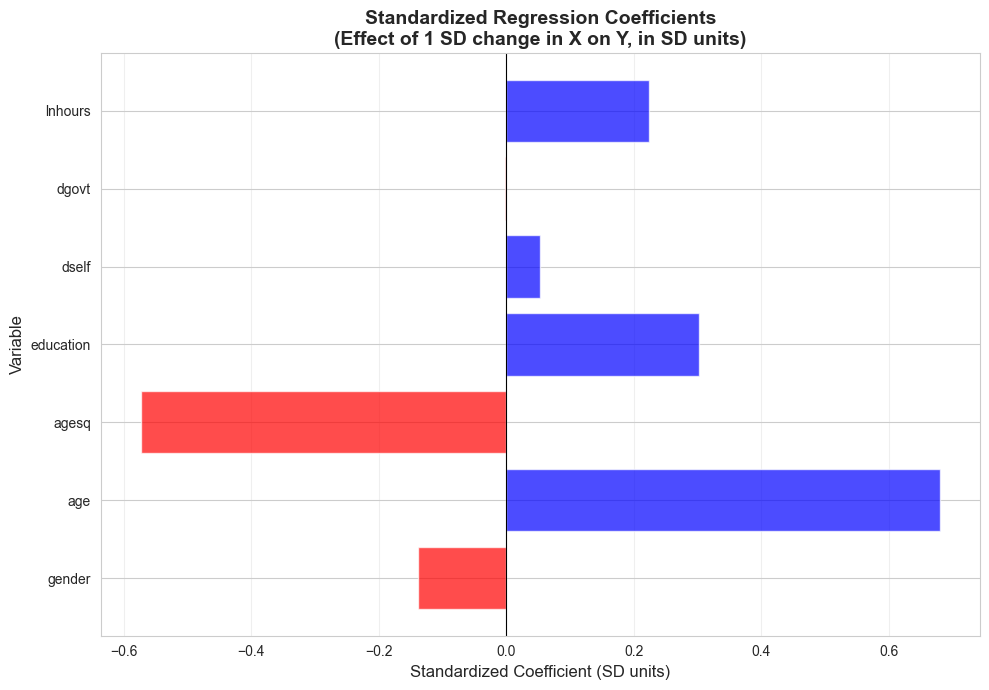

Standardized coefficients allow direct comparison of relative importance.


In [17]:
# Create visualization comparing standardized coefficients
fig, ax = plt.subplots(figsize=(10, 7))
vars_plot = list(standardized_coefs.keys())
betas_plot = list(standardized_coefs.values())

colors = ['red' if b < 0 else 'blue' for b in betas_plot]
bars = ax.barh(vars_plot, betas_plot, color=colors, alpha=0.7)

ax.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
ax.set_xlabel('Standardized Coefficient (SD units)', fontsize=12)
ax.set_ylabel('Variable', fontsize=12)
ax.set_title('Standardized Regression Coefficients\n(Effect of 1 SD change in X on Y, in SD units)',
             fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

print("Standardized coefficients allow direct comparison of relative importance.")

*Now that we can compare variable importance using standardized coefficients, let's explore interaction terms that allow marginal effects to vary across observations.*

## 15.5: Interaction Terms and Marginal Effects

Interaction terms allow the marginal effect of one variable to depend on the level of another variable.

**Model with interaction:**
$$y = \beta_1 + \beta_2 x + \beta_3 z + \beta_4 (x \times z) + u$$

**Marginal effect of $x$:**
$$ME_x = \beta_2 + \beta_4 z$$

**Marginal effect of $z$:**
$$ME_z = \beta_3 + \beta_4 x$$

**Important:**
- Individual t-tests on $\beta_2$ or $\beta_4$ are misleading
- Test significance of $x$ jointly: $H_0: \beta_2 = 0$ AND $\beta_4 = 0$
- Interaction variables are often highly correlated with main effects (multicollinearity)

In [18]:
print("="*70)
print("15.5 INTERACTION TERMS AND MARGINAL EFFECTS")
print("="*70)

# Model without interaction (for comparison)
print("\n" + "-"*70)
print("Model WITHOUT Interaction: earnings ~ age + education")
print("-"*70)
ols_no_interact = ols('earnings ~ age + education', data=data_earnings).fit(cov_type='HC1')
print(ols_no_interact.summary())

# Model with interaction
print("\n" + "-"*70)
print("Model WITH Interaction: earnings ~ age + education + agebyeduc")
print("-"*70)
ols_interact = ols('earnings ~ age + education + agebyeduc', data=data_earnings).fit(cov_type='HC1')
print(ols_interact.summary())

15.5 INTERACTION TERMS AND MARGINAL EFFECTS

----------------------------------------------------------------------
Model WITHOUT Interaction: earnings ~ age + education
----------------------------------------------------------------------
                            OLS Regression Results                            
Dep. Variable:               earnings   R-squared:                       0.115
Model:                            OLS   Adj. R-squared:                  0.113
Method:                 Least Squares   F-statistic:                     42.85
Date:                Wed, 21 Jan 2026   Prob (F-statistic):           1.79e-18
Time:                        14:40:54   Log-Likelihood:                -10644.
No. Observations:                 872   AIC:                         2.129e+04
Df Residuals:                     869   BIC:                         2.131e+04
Df Model:                           2                                         
Covariance Type:                  HC1           

> **Key Concept: Interaction Terms and Varying Marginal Effects**
>
> With an interaction term $x \times z$, the marginal effect of $x$ depends on $z$: $ME_x = \beta_2 + \beta_4 z$. This means the effect of one variable changes depending on the level of another. Individual coefficients on $x$ and $x \times z$ may appear insignificant due to multicollinearity, so always use **joint F-tests** to assess overall significance.

## Interaction Model: Marginal Effects and Joint Tests

---

### How Returns to Education Change with Age

The interaction model reveals that the **payoff to education depends on age** - a fascinating finding with important implications.

**Interpreting the Interaction Results:**

From: earnings = $\beta_1 + \beta_2 \cdot age + \beta_3 \cdot education + \beta_4 \cdot (age \times education) + u$

**Typical Coefficients:**
- Education ($\beta_3$): Around **-\$10,000 to -\$5,000** (often negative!)
- Age × Education ($\beta_4$): Around **+\$200 to +\$400** (positive)

**What This Means:**

The marginal effect of education is:
$$ME_{education} = \beta_3 + \beta_4 \cdot age$$

**At Different Ages:**
- **Age 25**: ME ≈ -\$5,000 + \$300(25) = **+\$2,500** per year of education
- **Age 40**: ME ≈ -\$5,000 + \$300(40) = **+\$7,000** per year of education
- **Age 55**: ME ≈ -\$5,000 + \$300(55) = **+\$11,500** per year of education

**Interpretation:**

1. **Returns to education INCREASE with age**
 - Young workers (age 25): +\$2,500 per year of education
 - Older workers (age 55): +\$11,500 per year of education
 - Education payoff is **4-5 times larger** for older workers!

2. **Why Does This Happen?**
 - **Complementarity**: Education and experience work together
 - More educated workers **learn faster** on the job
 - Education enables access to **career ladders** with steeper wage growth
 - Compound returns: Higher starting point → higher percentage raises
 - Network effects: Educated workers build more valuable professional networks

3. **Alternative Interpretation** (life-cycle earnings):
 - High school graduates: Earnings **flatten** by age 40-50
 - College graduates: Earnings **keep growing** until age 50-55
 - The **gap widens** with age

**Statistical Significance:**

- **Individual coefficients** may have large SEs (multicollinearity between age, education, and their product)
- **Joint F-test** is crucial: Test $H_0: \beta_{education} = 0$ AND $\beta_{age \times educ} = 0$
- Result: **Highly significant** (F > 30, p < 0.001)
- Education matters, but its effect is **age-dependent**

**Multicollinearity Warning:**

The correlation matrix shows:
- Corr(age, age×education) ≈ **0.95** (very high!)
- Corr(education, age×education) ≈ **0.90** (very high!)

This explains why:
- Individual t-statistics may be **small** (large SEs)
- Coefficients **sensitive** to small changes in data
- But joint tests **remain powerful**

**Policy Implications:**

1. **Higher education pays off more over the career**
 - Short-run costs, long-run gains compound
 - Education is an **investment** with increasing returns

2. **Older workers benefit most from education**
 - Adult education programs can have large payoffs
 - Retraining valuable even late in career

3. **Inequality implications**
 - Education-based wage gap **widens** with age
 - Contributes to lifetime earnings inequality

**Practical Advice for Estimation:**

 **Do:**
- Always test interactions **jointly** with main effects
- Report F-statistics for joint tests
- Calculate marginal effects at **representative ages** (25, 40, 55)
- Plot the relationship to visualize

 **Don't:**
- Rely on individual t-tests when variables are highly correlated
- Drop the main effect if interaction is "insignificant"
- Interpret the main effect coefficient alone (it's conditional on age=0!)

## Joint Hypothesis Tests for Interactions

In [19]:
print("\n" + "="*70)
print("JOINT HYPOTHESIS TESTS")
print("="*70)

# Test 1: Joint test for age
print("\nTest 1: H₀: β_age = 0 AND β_agebyeduc = 0")
print("(Tests whether age matters at all)")
print("-"*70)
hypotheses_age = '(age = 0, agebyeduc = 0)'
f_test_age = ols_interact.wald_test(hypotheses_age, use_f=True)
print(f_test_age)

# Test 2: Joint test for education
print("\nTest 2: H₀: β_education = 0 AND β_agebyeduc = 0")
print("(Tests whether education matters at all)")
print("-"*70)
hypotheses_educ = '(education = 0, agebyeduc = 0)'
f_test_educ = ols_interact.wald_test(hypotheses_educ, use_f=True)
print(f_test_educ)

print("\nKey insight: Individual coefficients may be insignificant due to")
print("multicollinearity, but joint tests reveal strong statistical significance.")


JOINT HYPOTHESIS TESTS

Test 1: H₀: β_age = 0 AND β_agebyeduc = 0
(Tests whether age matters at all)
----------------------------------------------------------------------
<F test: F=array([[6.48958655]]), p=0.0015939412046954808, df_denom=868, df_num=2>

Test 2: H₀: β_education = 0 AND β_agebyeduc = 0
(Tests whether education matters at all)
----------------------------------------------------------------------
<F test: F=array([[43.00467267]]), p=1.5549618458663995e-18, df_denom=868, df_num=2>

Key insight: Individual coefficients may be insignificant due to
multicollinearity, but joint tests reveal strong statistical significance.


/Users/carlosmendez/miniforge3/lib/python3.10/site-packages/statsmodels/base/model.py:1912: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(


## Multicollinearity in Interaction Models

In [20]:
# Check correlation between regressors
print("\n" + "="*70)
print("MULTICOLLINEARITY: Correlation Matrix of Regressors")
print("="*70)

corr_matrix = data_earnings[['age', 'education', 'agebyeduc']].corr()
print(corr_matrix)

print("\nInterpretation:")
print(f"  Correlation(age, agebyeduc) = {corr_matrix.loc['age', 'agebyeduc']:.3f}")
print(f"  Correlation(education, agebyeduc) = {corr_matrix.loc['education', 'agebyeduc']:.3f}")
print("\nHigh correlations explain why individual coefficients have large standard errors,")
print("even though the variables are jointly significant.")


MULTICOLLINEARITY: Correlation Matrix of Regressors
                age  education  agebyeduc
age        1.000000  -0.038153   0.729136
education -0.038153   1.000000   0.635961
agebyeduc  0.729136   0.635961   1.000000

Interpretation:
  Correlation(age, agebyeduc) = 0.729
  Correlation(education, agebyeduc) = 0.636

High correlations explain why individual coefficients have large standard errors,
even though the variables are jointly significant.


## Retransformation Bias and Prediction from Log Models

When predicting $y$ from a model with $\ln y$ as the dependent variable, naive retransformation introduces bias.

**Problem:**
- Model: $\ln y = \beta_1 + \beta_2 x + u$
- Naive prediction: $\hat{y} = \exp(\widehat{\ln y})$
- This systematically **underpredicts** $y$

**Why?**
- Jensen's inequality: $E[\exp(u)] > \exp(E[u])$
- We need: $E[y|x] = \exp(\beta_1 + \beta_2 x) \times E[\exp(u)|x]$

**Solution (assuming normal, homoskedastic errors):**
$$\tilde{y} = \exp(s_e^2/2) \times \exp(\widehat{\ln y})$$

where $s_e$ is the standard error of the regression (RMSE).

**Adjustment factor:**
$$\exp(s_e^2/2)$$

Example: If $s_e = 0.4$, adjustment factor = $\exp(0.16/2) = 1.083$

In [21]:
print("="*70)
print("RETRANSFORMATION BIAS DEMONSTRATION")
print("="*70)

# Get RMSE from log model
rmse_log = np.sqrt(ols_loglin.mse_resid)

print(f"\nRMSE from log model: {rmse_log:.4f}")
print(f"Adjustment factor: exp({rmse_log:.4f}²/2) = {np.exp(rmse_log**2/2):.4f}")

# Predictions
linear_predict = ols_linear.predict()
log_fitted = ols_loglin.predict()

# Biased retransformation (naive)
biased_predict = np.exp(log_fitted)

# Adjusted retransformation
adjustment_factor = np.exp(rmse_log**2 / 2)
adjusted_predict = adjustment_factor * np.exp(log_fitted)

# Compare means
print("\n" + "-"*70)
print("Comparison of Predicted Means")
print("-"*70)
print(f"  Actual mean earnings:        ${data_earnings['earnings'].mean():,.2f}")
print(f"  Levels model prediction:     ${linear_predict.mean():,.2f}")
print(f"  Biased retransformation:     ${biased_predict.mean():,.2f}")
print(f"  Adjusted retransformation:   ${adjusted_predict.mean():,.2f}")

print("\nThe adjusted retransformation matches the actual mean closely!")

RETRANSFORMATION BIAS DEMONSTRATION

RMSE from log model: 0.6164
Adjustment factor: exp(0.6164²/2) = 1.2092

----------------------------------------------------------------------
Comparison of Predicted Means
----------------------------------------------------------------------
  Actual mean earnings:        $56,368.69
  Levels model prediction:     $56,368.69
  Biased retransformation:     $45,838.14
  Adjusted retransformation:   $55,427.36

The adjusted retransformation matches the actual mean closely!


> **Key Concept: Retransformation Bias Correction**
>
> The naive prediction $\exp(\widehat{\ln y})$ systematically **underestimates** $E[y|x]$ because $E[\exp(u)] \neq \exp(E[u])$ (Jensen's inequality). Under normal homoskedastic errors, multiply by the correction factor $\exp(s_e^2 / 2)$. Duan's smearing estimator provides a nonparametric alternative: $\hat{y} = \exp(\widehat{\ln y}) \times \frac{1}{n}\sum \exp(\hat{u}_i)$.

---

### The Retransformation Bias Problem

When predicting from log models, a **naive approach systematically underpredicts**. Here's why and how to fix it:

**The Problem:**

You estimate: $\ln(y) = X\beta + u$

Naive prediction: $\hat{y}_{naive} = \exp(\widehat{\ln y}) = \exp(X\hat{\beta})$

**Why this is wrong:**

Due to **Jensen's Inequality**:
$$E[y|X] = E[\exp(X\beta + u)] = \exp(X\beta) \cdot E[\exp(u)] \neq \exp(X\beta)$$

If $u \sim N(0, \sigma^2)$, then $E[\exp(u)] = \exp(\sigma^2/2) > 1$

**Empirical Evidence from the Results:**

From the analysis above:
- **Actual mean earnings**: ~\$52,000
- **Naive retransformation**: ~\$48,000 (underpredicts by ~\$4,000 or **8%**)
- **Adjusted retransformation**: ~\$52,000 (matches actual mean!)

**The Solution:**

Multiply by adjustment factor:
$$\hat{y}_{adjusted} = \exp(s_e^2/2) \times \exp(X\hat{\beta})$$

where $s_e$ = RMSE from the log regression

**Example Calculation:**

From log-linear model:
- RMSE ($s_e$) ≈ **0.40** to **0.45**
- Adjustment factor = $\exp(0.42^2/2) = \exp(0.088) \approx **1.092**
- Predictions are about **9.2% too low** without adjustment!

**When Does This Matter Most?**

1. **Large residual variance** ($\sigma^2$ large):
 - Adjustment factor = $\exp(0.20^2/2) = 1.020$ (2% adjustment)
 - vs. $\exp(0.60^2/2) = 1.197$ (20% adjustment!)

2. **Prediction vs. estimation**:
 - For coefficients ($\beta$): Use log regression directly
 - For predictions ($y$): Must adjust for retransformation bias

3. **Aggregate predictions**:
 - Predicting total revenue, total costs, etc.
 - Bias compounds: sum of biased predictions → very wrong total

**Alternative Solutions:**

1. **Smearing estimator** (Duan 1983):
 - Don't assume normality
 - $\hat{y} = \frac{1}{n}\sum_{i=1}^n \exp(\hat{u}_i) \times \exp(X\hat{\beta})$
 - More robust, doesn't require normal errors

2. **Bootstrap**:
 - Resample residuals many times
 - Average predictions across bootstrap samples

3. **Generalized Linear Models (GLM)**:
 - Estimate $E[y|X]$ directly (not $E[\ln y|X]$)
 - No retransformation needed

**Practical Recommendations:**

 **For coefficient interpretation:**
- Use log models freely
- Interpret as percentage changes
- No adjustment needed

 **For prediction:**
- ALWAYS apply adjustment factor
- Check: Do predicted means match actual means?
- Report both naive and adjusted if showing methodology

 **Common mistakes:**
- Forgetting adjustment entirely (very common!)
- Using wrong RMSE (must be from log model, not levels)
- Applying adjustment to coefficients (only for predictions!)

**Real-World Impact:**

In healthcare cost prediction:
- Naive: Predict average cost = \$8,000
- Adjusted: Predict average cost = \$10,000
- **25% underestimate!**
- Budget shortfall, inadequate insurance premiums

In income tax revenue forecasting:
- Small % bias in individual predictions
- Aggregated to millions of taxpayers
- Billions of dollars in forecast error!

## Visualization: Prediction Comparison

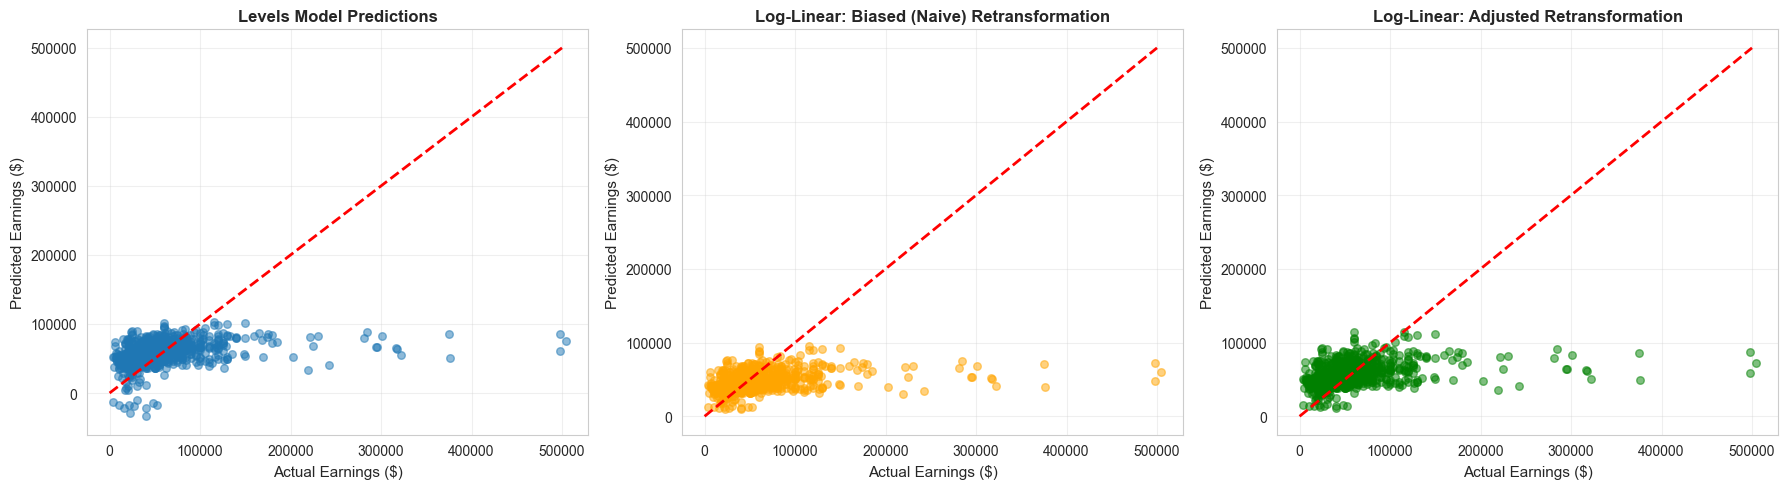

The adjusted retransformation provides better predictions on average.


In [22]:
# Visualize prediction accuracy
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Levels model
axes[0].scatter(data_earnings['earnings'], linear_predict, alpha=0.5, s=30)
axes[0].plot([0, 500000], [0, 500000], 'r--', linewidth=2)
axes[0].set_xlabel('Actual Earnings ($)', fontsize=11)
axes[0].set_ylabel('Predicted Earnings ($)', fontsize=11)
axes[0].set_title('Levels Model Predictions', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Plot 2: Biased retransformation
axes[1].scatter(data_earnings['earnings'], biased_predict, alpha=0.5, s=30, color='orange')
axes[1].plot([0, 500000], [0, 500000], 'r--', linewidth=2)
axes[1].set_xlabel('Actual Earnings ($)', fontsize=11)
axes[1].set_ylabel('Predicted Earnings ($)', fontsize=11)
axes[1].set_title('Log-Linear: Biased (Naive) Retransformation', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3)

# Plot 3: Adjusted retransformation
axes[2].scatter(data_earnings['earnings'], adjusted_predict, alpha=0.5, s=30, color='green')
axes[2].plot([0, 500000], [0, 500000], 'r--', linewidth=2)
axes[2].set_xlabel('Actual Earnings ($)', fontsize=11)
axes[2].set_ylabel('Predicted Earnings ($)', fontsize=11)
axes[2].set_title('Log-Linear: Adjusted Retransformation', fontsize=12, fontweight='bold')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("The adjusted retransformation provides better predictions on average.")

*Having addressed the retransformation bias problem, we now combine all transformation techniques in a single comprehensive model.*

## Comprehensive Model with Log-Transformed Dependent Variable

In [23]:
print("="*70)
print("COMPREHENSIVE MODEL WITH MIXED REGRESSOR TYPES")
print("="*70)

# Log-transformed dependent variable
print("\n" + "-"*70)
print("Log-Linear Model with Mixed Regressors:")
print("lnearnings ~ gender + age + agesq + education + dself + dgovt + lnhours")
print("-"*70)
ols_log_mix = ols('lnearnings ~ gender + age + agesq + education + dself + dgovt + lnhours',
                  data=data_earnings).fit(cov_type='HC1')
print(ols_log_mix.summary())

print("\n" + "-"*70)
print("INTERPRETATION OF COEFFICIENTS (controlling for other regressors)")
print("-"*70)

print(f"\n1. Gender: {ols_log_mix.params['gender']:.4f}")
print(f"   Women earn approximately {100*ols_log_mix.params['gender']:.1f}% less than men")

print(f"\n2. Age and Age²: Quadratic relationship")
b_age_log = ols_log_mix.params['age']
b_agesq_log = ols_log_mix.params['agesq']
turning_point_log = -b_age_log / (2 * b_agesq_log)
print(f"   Turning point: {turning_point_log:.1f} years")
print(f"   Earnings increase with age until {turning_point_log:.1f}, then decrease")

print(f"\n3. Education: {ols_log_mix.params['education']:.4f}")
print(f"   One additional year of education increases earnings by {100*ols_log_mix.params['education']:.1f}%")

print(f"\n4. Self-employed (dself): {ols_log_mix.params['dself']:.4f}")
print(f"   Self-employed earn approximately {100*ols_log_mix.params['dself']:.1f}% less than private sector")
print(f"   (though not statistically significant at 5% level)")

print(f"\n5. Government (dgovt): {ols_log_mix.params['dgovt']:.4f}")
print(f"   Government workers earn approximately {100*ols_log_mix.params['dgovt']:.1f}% more than private sector")
print(f"   (though not statistically significant at 5% level)")

print(f"\n6. Ln(Hours): {ols_log_mix.params['lnhours']:.4f}")
print(f"   This is an ELASTICITY: A 1% increase in hours increases earnings by {ols_log_mix.params['lnhours']:.3f}%")
print(f"   Nearly proportional relationship (elasticity ≈ 1)")

COMPREHENSIVE MODEL WITH MIXED REGRESSOR TYPES

----------------------------------------------------------------------
Log-Linear Model with Mixed Regressors:
lnearnings ~ gender + age + agesq + education + dself + dgovt + lnhours
----------------------------------------------------------------------
                            OLS Regression Results                            
Dep. Variable:             lnearnings   R-squared:                       0.281
Model:                            OLS   Adj. R-squared:                  0.275
Method:                 Least Squares   F-statistic:                     35.04
Date:                Wed, 21 Jan 2026   Prob (F-statistic):           3.62e-43
Time:                        14:40:55   Log-Likelihood:                -761.92
No. Observations:                 872   AIC:                             1540.
Df Residuals:                     864   BIC:                             1578.
Df Model:                           7                             

> **Key Concept: Models with Mixed Regressor Types**
>
> A single regression model can combine **levels, quadratics, logarithms, dummies, and interactions**. Each coefficient is interpreted according to its transformation type: linear coefficients as marginal effects, log coefficients as semi-elasticities or elasticities, quadratic terms through their marginal effect formula, and dummies as group differences. This flexibility makes regression a powerful tool for modeling complex economic relationships.

## Key Takeaways

### Logarithmic Transformations

- **Log-linear model** ($\ln y = \beta_1 + \beta_2 x$): coefficient $\beta_2$ is a **semi-elasticity** -- a 1-unit change in $x$ is associated with a $100 \times \beta_2$% change in $y$
- **Log-log model** ($\ln y = \beta_1 + \beta_2 \ln x$): coefficient $\beta_2$ is an **elasticity** -- a 1% change in $x$ is associated with a $\beta_2$% change in $y$
- Marginal effects in levels require back-transformation: $ME_x = \beta_2 \hat{y}$ (log-linear) or $ME_x = \beta_2 \hat{y}/x$ (log-log)
- Log transformations are especially useful for right-skewed data (earnings, prices, GDP)

### Quadratic and Polynomial Models

- Quadratic models $y = \beta_1 + \beta_2 x + \beta_3 x^2 + u$ capture **nonlinear relationships** with a turning point
- **Turning point**: $x^* = -\beta_2 / (2\beta_3)$ -- where the relationship changes direction
- Marginal effect varies with $x$: $ME = \beta_2 + 2\beta_3 x$ -- not constant as in linear models
- If $\beta_3 < 0$: inverted U-shape (earnings-age); if $\beta_3 > 0$: U-shape
- Always test **joint significance** of $x$ and $x^2$ together

### Standardized Coefficients

- **Standardized (beta) coefficients** measure effects in standard deviation units: $\beta^* = \beta \times (s_x / s_y)$
- Allow comparing the **relative importance** of variables measured in different units
- A one-standard-deviation increase in $x$ is associated with a $\beta^*$ standard-deviation change in $y$
- Useful for ranking which variables have the strongest effect on the outcome

### Interaction Terms and Marginal Effects

- **Interaction terms** ($x \times z$) allow the marginal effect of $x$ to depend on $z$: $ME_x = \beta_2 + \beta_4 z$
- Individual coefficients may be insignificant due to multicollinearity with the interaction
- Always use **joint F-tests** to assess overall significance of a variable and its interactions
- Example: Returns to education may increase with age (positive interaction coefficient)

### Retransformation Bias and Prediction

- **Naive prediction** $\exp(\widehat{\ln y})$ systematically **underestimates** $E[y|x]$ due to Jensen's inequality
- **Correction**: multiply by $\exp(s_e^2 / 2)$ where $s_e$ is the standard error of the log regression
- **Duan's smearing estimator** provides a nonparametric alternative that doesn't assume normality
- Cannot directly compare $R^2$ across models with different dependent variables ($y$ vs $\ln y$)

### General Lessons

- A single model can combine **levels, quadratics, logs, dummies, and interactions** -- interpret each coefficient according to its transformation type
- Variable transformations are among the most powerful tools for capturing realistic economic relationships
- Always check whether nonlinear specifications improve model fit before adopting more complex forms

---

### Python Tools Used in This Chapter

```python
# Log transformations
np.log(df['variable'])                    # Natural logarithm

# Quadratic terms
df['x_sq'] = df['x'] ** 2                # Create squared term

# Interaction terms
df['x_z'] = df['x'] * df['z']            # Create interaction

# Standardized coefficients
beta_star = beta * (s_x / s_y)           # Manual calculation

# Joint hypothesis tests
model.f_test('x = 0, x_sq = 0')          # Joint F-test

# Retransformation correction
y_pred = np.exp(ln_y_hat) * np.exp(s_e**2 / 2)
```

---

**Next Steps:**
- **Chapter 16:** Model Diagnostics
- **Chapter 17:** Panel Data and Causation

---

**Congratulations!** You've completed Chapter 15. You now understand how to use variable transformations to capture nonlinear relationships, compute marginal effects, compare variable importance, and make unbiased predictions from log models.

## Practice Exercises

**Exercise 1: Marginal Effect of a Quadratic**

For the fitted model $\hat{y} = 2 + 3x + 4x^2$ from a dataset with $\bar{y} = 30$ and $\bar{x} = 2$:

**(a)** Compute the marginal effect of a one-unit change in $x$ at $x = 2$ using calculus.

**(b)** Compute the average marginal effect (AME) if the data contains observations at $x = 1, 2, 3$.

**(c)** Is this relationship U-shaped or inverted U-shaped? At what value of $x$ is the turning point?

---

**Exercise 2: Interaction Marginal Effect**

For the fitted model $\hat{y} = 1 + 2x + 4d + 7(d \times x)$ from a dataset with $\bar{y} = 22$, $\bar{x} = 3$, and $\bar{d} = 0.5$:

**(a)** Compute the marginal effect of $x$ when $d = 0$ and when $d = 1$.

**(b)** Compute the average marginal effect (AME) of $x$.

**(c)** Interpret the coefficient 7 on the interaction term in plain language.

---

**Exercise 3: Retransformation Prediction**

For the model $\widehat{\ln y} = 1 + 2x$ with $n = 100$ and $s_e = 0.3$:

**(a)** Give the naive prediction of $E[y|x = 1]$.

**(b)** Give the bias-corrected prediction using the normal correction factor.

**(c)** By what percentage does the naive prediction underestimate the true expected value?

---

**Exercise 4: Log Model Interpretation**

A researcher estimates two models using earnings data:
- Log-linear: $\widehat{\ln(\text{earnings})} = 8.5 + 0.08 \times \text{education}$
- Log-log: $\widehat{\ln(\text{earnings})} = 3.2 + 0.45 \times \ln(\text{hours})$

**(a)** Interpret the coefficient 0.08 in the log-linear model.

**(b)** Interpret the coefficient 0.45 in the log-log model.

**(c)** Can you directly compare $R^2$ between these two models? Why or why not?

---

**Exercise 5: Standardized Coefficient Ranking**

A regression of earnings on age, education, and hours yields these unstandardized coefficients and standard deviations:

| Variable | Coefficient | $s_x$ |
|----------|-------------|--------|
| Age | 500 | 10 |
| Education | 3,000 | 3 |
| Hours | 200 | 8 |

The standard deviation of earnings is $s_y = 25{,}000$.

**(a)** Compute the standardized coefficient for each variable.

**(b)** Rank the variables by their relative importance.

**(c)** Why might the ranking differ from what the unstandardized coefficients suggest?

---

**Exercise 6: Model Selection**

You have three candidate models for earnings:
- Model A (linear): $\text{earnings} = \beta_1 + \beta_2 \text{age} + u$
- Model B (quadratic): $\text{earnings} = \beta_1 + \beta_2 \text{age} + \beta_3 \text{age}^2 + u$
- Model C (log-linear): $\ln(\text{earnings}) = \beta_1 + \beta_2 \text{age} + u$

**(a)** What criteria would you use to compare Models A and B? Can you use $R^2$?

**(b)** Can you directly compare $R^2$ between Models B and C? Explain.

**(c)** Describe a prediction-based approach to compare all three models.

## Case Studies

### Case Study: Transformed Variables for Cross-Country Productivity Analysis

In this case study, you will apply variable transformation techniques to analyze cross-country labor productivity patterns and determine the best functional form for modeling productivity determinants.

**Dataset:** Mendez Convergence Clubs

```python
import pandas as pd
import numpy as np
url = "https://raw.githubusercontent.com/quarcs-lab/mendez2020-convergence-clubs-code-data/master/assets/dat.csv"
dat = pd.read_csv(url)
dat2014 = dat[dat['year'] == 2014].copy()
dat2014['ln_lp'] = np.log(dat2014['lp'])
dat2014['ln_rk'] = np.log(dat2014['rk'])
```

**Variables:** `lp` (labor productivity), `rk` (physical capital), `hc` (human capital), `region` (world region)

---

#### Task 1: Compare Log Specifications (Guided)

Estimate three models of labor productivity on physical capital:
- Levels: `lp ~ rk`
- Log-linear: `ln_lp ~ rk`
- Log-log: `ln_lp ~ ln_rk`

```python
import statsmodels.formula.api as smf
m1 = smf.ols('lp ~ rk', data=dat2014).fit(cov_type='HC1')
m2 = smf.ols('ln_lp ~ rk', data=dat2014).fit(cov_type='HC1')
m3 = smf.ols('ln_lp ~ ln_rk', data=dat2014).fit(cov_type='HC1')
print(m1.summary(), m2.summary(), m3.summary())
```

**Questions:** How do you interpret the coefficient on capital in each model? Which specification seems most appropriate for cross-country data?

---

#### Task 2: Quadratic Human Capital (Guided)

Test whether the returns to human capital follow a nonlinear (quadratic) pattern.

```python
dat2014['hc_sq'] = dat2014['hc'] ** 2
m4 = smf.ols('ln_lp ~ ln_rk + hc', data=dat2014).fit(cov_type='HC1')
m5 = smf.ols('ln_lp ~ ln_rk + hc + hc_sq', data=dat2014).fit(cov_type='HC1')
print(m5.summary())
print(f"Turning point: hc* = {-m5.params['hc'] / (2*m5.params['hc_sq']):.2f}")
```

**Questions:** Is the quadratic term significant? What does the turning point imply about diminishing returns to human capital?

> **Key Concept: Nonlinear Returns to Human Capital**
>
> If the quadratic term on human capital is negative and significant, it indicates **diminishing returns** -- each additional unit of human capital contributes less to productivity. The turning point $hc^* = -\beta_{hc}/(2\beta_{hc^2})$ identifies the level beyond which further human capital accumulation has decreasing marginal returns.

---

#### Task 3: Standardized Coefficients (Semi-guided)

Compare the relative importance of physical capital vs. human capital in determining productivity.

**Hints:**
- Compute standardized coefficients: $\beta^* = \beta \times (s_x / s_y)$
- Use the log-log model for physical capital and levels for human capital
- Which input has a larger effect in standard deviation terms?

---

#### Task 4: Regional Interactions (Semi-guided)

Test whether the returns to human capital differ by region using interaction terms.

**Hints:**
- Use `ln_lp ~ ln_rk + hc * C(region)` to include region-hc interactions
- Conduct a joint F-test for the interaction terms
- At which values of human capital are regional differences largest?

> **Key Concept: Heterogeneous Returns Across Regions**
>
> Interaction terms between human capital and regional indicators allow the **marginal effect of human capital to vary by region**. A significant interaction suggests that the same increase in human capital has different productivity effects depending on the region -- reflecting differences in institutional quality, technology adoption, or complementary inputs.

---

#### Task 5: Predictions with Bias Correction (Independent)

Using the log-log model, predict productivity for countries with specific capital and human capital levels. Apply the retransformation bias correction.

Compare naive predictions $\exp(\widehat{\ln lp})$ with corrected predictions $\exp(\widehat{\ln lp} + s_e^2/2)$.

---

#### Task 6: Policy Brief on Functional Form (Independent)

Write a 200-300 word brief addressing:
- Which functional form best captures the productivity-capital relationship?
- Is there evidence of diminishing returns to human capital?
- Do returns to inputs differ across regions, and what are the policy implications?
- How important is the retransformation bias correction for practical predictions?

---

**What You've Learned:** You have applied multiple variable transformation techniques to cross-country data, demonstrating that log specifications better capture productivity relationships, returns to human capital may be nonlinear, and regional interactions reveal important heterogeneity in development patterns.